In [1]:
# ! pip install multiprocess --user

In [2]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.decomposition import PCA

import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import figure
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
matplotlib.rcParams.update({'font.size': 22})
import seaborn as sns

print(__doc__)

from time import time

from multiprocess import Pool

Automatically created module for IPython interactive environment


## Read in data as csv 

In [3]:
data=pd.read_table('/Users/gracer/Google Drive/ABCD/important_txt/4Kmeans.csv', sep=',')

## Seperate by sex

In [4]:
dudes = data[data['sex'] == 0]
lady_dudes = data[data['sex'] == 1]

## Get a List of variable names

In [5]:
var_names=list(dudes.columns.values)
cols = dudes.columns
dudes.columns = ['sub','pds_ht2_y',  'pds_skin2_y',  'pds_bdyhair_y','labels_true',
            'pds_f4_2_y',  'pds_f5_y',  'pds_m4_y', 'pds_m5_y', 'interview_age', 'gender',
             'anthroheightcalc',  'anthroweightcalc',  'anthro_waist_cm',
             'hormone_scr_dhea_mean',  'hormone_scr_hse_mean',  'hormone_scr_ert_mean',  'sex']
# print(dudes)
# cols[1]

## Combine variables of interest into a single matrix

In [6]:
labels_true=dudes['labels_true'].values
subs=dudes['sub'].values
f2=dudes['pds_ht2_y'].values
f3=dudes['pds_skin2_y'].values
f4=dudes['pds_bdyhair_y'].values
f5=dudes['pds_m4_y'].values
f6=dudes['pds_m5_y'].values
f7=dudes['interview_age'].values
f8=dudes['anthroheightcalc'].values 
f9=dudes['anthroweightcalc'].values
f10=dudes['anthro_waist_cm'].values
f11=dudes['hormone_scr_dhea_mean'].values
f12=dudes['hormone_scr_hse_mean'].values
X=np.matrix(zip(f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12))

## Create a list of the variable names included in this analyses

In [7]:
names=['pds_ht2_y',
'pds_skin2_y',
'pds_bdyhair_y',
'pds_m4_y',
'pds_m5_y',
'interview_age',
'anthroheightcalc', 
'anthroweightcalc',
'anthro_waist_cm',
'hormone_scr_dhea_mean',
'hormone_scr_hse_mean']

## Check the data 

[(1, 917), (2, 354), (3, 14), (4, 1)]

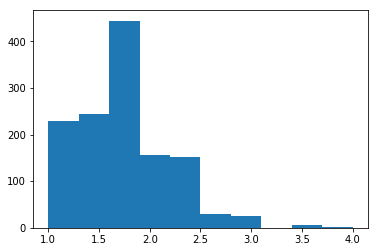

In [8]:
%matplotlib inline
plt.hist(labels_true)
y = np.bincount(labels_true.astype(int))
ii = np.nonzero(y)[0]
zip(ii,y[ii])

An issue is a low number of people in groups 3 and 4

## Possible solution, randomly sample equal numbers
Using the rule of thumb 2^m I need 8 people per cluster 
Possible combinations below

In [9]:
import math
x=math.factorial(70)
y=math.factorial(70-20)
fact=x/y
print(fact)

393849377343759797528386895216640000


## Create target variable (or the one you are comparing)

In [10]:
target_var=pd.DataFrame(dudes['labels_true'].values)
subs_var=pd.DataFrame(subs)
target_var.shape

(1286, 1)

## Impute missing values
This will not allow missing data, so have to impute nans

In [11]:
imputer = Imputer()
transformed_values = imputer.fit_transform(X)
# count the number of NaN values in each column
print(np.isnan(transformed_values).sum()) 
transformed_values_scale = scale(transformed_values)
transformed_values_scale.shape
#the target variable is the last variable
trans = np.column_stack((transformed_values_scale,subs,target_var.round(decimals=0)))

0


In [37]:
print(trans.shape)
trans[10,:]

(1286, 13)


array([1.8072925722558837, -0.76143892783116, -0.8138529876663042,
       -0.7900238054620263, -0.4657408067722271, 0.20524522333698994,
       -0.03553911606346546, -0.6818664863111453, -0.7052779366854639,
       -0.88197843756715, 1.3980210376008525e-14, 'NDAR_INV0CBPKF6W', 2.0], dtype=object)

## Function to randomly sample the data and perform the kmeans

In [13]:
def bench_k_means(estimator, name, data):
        t0 = time() #time
        estimator.fit(data) #estimating the fit 
        print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
              % (name, (time() - t0), estimator.inertia_,
                 metrics.homogeneity_score(labels, estimator.labels_),
                 metrics.completeness_score(labels, estimator.labels_),
                 metrics.v_measure_score(labels, estimator.labels_),
                 metrics.adjusted_rand_score(labels, estimator.labels_),
                 metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
                 metrics.silhouette_score(data, estimator.labels_,
                                          metric='euclidean',
                                          sample_size=sample_size)))


In [14]:
def meaner(**kwargs):
    for x in kwargs.items():
        print(x)
#     z=sum(*arg)/len(*arg)
#     return z

In [15]:
def PCA_reducer(DATA):
    n_samples, n_features = DATA.shape
    labels = np.round(targets)
    n_digits = len(np.unique(targets))
    sample_size=n_samples
    
    PCA_results = PCA(n_components=2)
    reduced_data = PCA_results.fit_transform(DATA)
    
    # Dump components relations with features:
    print pd.DataFrame(PCA_results.components_,index = ['PC-1','PC-2'])
    plt.semilogy(PCA_results.explained_variance_ratio_, '--o')
    return (PCA_results.components_, PCA_results.explained_variance_ratio_, 
            PCA_results.explained_variance_, PCA_results.mean_) 
    


In [16]:
def split_list(a_list):
        half = len(a_list)/2
        return a_list[:half], a_list[half:]

In [55]:
def random_selct(DATA,i):
    dictr = {}
    #defining the levels, based on the final column add the values to the dictionary
    levels = ['lev1','lev2','lev3']
    i=1
    for lev in levels:
        if i < len(levels)+1:
            dictr[lev] = DATA[np.where(DATA[:,-1] == i)]
            i=i+1
    
    rand_dict={}
    target_dict={}
    ind_dict={}
    sub_dict = {}
    for key, value in dictr.iteritems():
        #shuffle the data's index
        ind = np.random.permutation(value.shape[0])#random index
        #get the first 20 subjects indexes
        training_idx = ind[:50]#get 20 subjects indexes
        #get the first 20 subjects
        value_data = value[:,0:10]
#         print(value_data[5,:])
        sub_data = value[:,11]
#         print(sub_data)
        label_data = value[:,-1]
        training = value_data[training_idx,:]#select 20 subjects from the value in the dictionary
        subs = sub_data[training_idx]
        labels_true = label_data[training_idx]
        #saving the true labels
#         labels_true = training[:,-1] #get the labels from the value in the dictiornary last column
        target_dict[key] = labels_true #add targets to dictionary
        rand_dict[key] = training #match the randomized data to the ind_dict by key 
        ind_dict[key] = training_idx #add the indexes to the dictionary
        sub_dict[key] = subs
    list_dicts = [rand_dict, target_dict, ind_dict, sub_dict]
    all_dicts = {}
    for d in list_dicts:
        all_dicts.update(d)
    
    '''
    combine all the dictionaries we have created thus far. 
    data, index, and targets
    '''
    
    #combine the randomized data by the actual level
    data=np.vstack((rand_dict['lev1'],rand_dict['lev2'],rand_dict['lev3']))
    
    ###################################################
    data=training# remove the label column
    ###################################################
    
    
    #combine the true labels into targets
    targets=np.hstack((target_dict['lev1'],target_dict['lev2'],target_dict['lev3']))
    #combine the indexes into one
    indexes=np.hstack((ind_dict['lev1'],ind_dict['lev2'],ind_dict['lev3']))
    subses=np.hstack((sub_dict['lev1'],sub_dict['lev2'],sub_dict['lev3']))
    
    '''
    defining the parameters for the k means and the PCA
    '''
    targets = targets.astype('int')
    n_samples, n_features = data.shape
    print(targets)
#    labels = np.round(targets)
    n_digits = len(np.unique(targets))
    sample_size=n_samples

    '''
    defining the parameters for the k means
    '''    
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=300)
    
    
    
    
    ###########################################
    #            rebuild to combine data      #
    ###########################################
    comb_data = np.column_stack((data, kmeans.fit_predict(data)))#makes first column the index value
#     full_data = np.column_stack((indexes, subses ,comb_data))#makes first column the index value
#     full_data = np.column_stack((full_data,labels))
    comb_dictr = {}
    '''
    seperating the data based on the fit predict value (found right above)
    '''
    i=0
    for lev in levels:
        if i < len(levels)+1:
            comb_dictr[lev] = comb_data[np.where(comb_data[:,-1] == i)]
            i=i+1
    '''
    defining the parameters for the PCA and running the PCA 
    '''
    ###########################################
    #            PCA                          #
    ###########################################
    PCA_dict={}
    PCA_data={}
    PCA_final = {}

    for key, value in comb_dictr.iteritems():
        PCA_dict[key] = PCA(n_components=2)
        #make sure the last column which is the predicted label isn't included
        PCA_data[key] = PCA_dict[key].fit_transform(value[:,0:11])
        #make sure the last column which is the predicted label isn't included
        ID = np.identity(value[:,0:11].shape[1])  # identity matrix
        coef = PCA_dict[key].transform(ID)
        PCA_final[key] = coef
        
        
        plt.semilogy(PCA_dict[key].explained_variance_ratio_, '--o', label = '%s'%key)
        plt.legend()
        plt.subplot(1, 2, 2)

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    plt.subplot(1, 2, 1)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
#     plt.show()
    
    ####THINGS TO SAVE#############################################################################        
    kmeans.fit(data)
    y_kmeans = kmeans.predict(data)
    clusters = kmeans.fit_predict(data)
    cluster_space = kmeans.fit_transform(data)
    
    
    
    centroids = kmeans.cluster_centers_   
    
    Components = np.vstack((PCA_dict['lev1'].components_,
                            PCA_dict['lev2'].components_,PCA_dict['lev3'].components_))
    
    Var_ratio = PCA_final
    
    lev1_VarRatio = np.vstack((PCA_final['lev1']))
    lev2_VarRatio = np.vstack((PCA_final['lev2']))
    lev3_VarRatio = np.vstack((PCA_final['lev3']))
    
    ind_dict = np.hstack((ind_dict['lev1'],
                            ind_dict['lev2'],ind_dict['lev3']))
    
    ########################################################################################################
    return (clusters, cluster_space,
            centroids,targets,
            all_dicts ,Components,
            Var_ratio, comb_data,
            lev1_VarRatio,lev2_VarRatio,lev3_VarRatio,
            kmeans,DATA)

# 0clusters
# 1cluster_space, 
# 2centroids, 
# 3targets, 
# 4all_dict,
# 5Components,
# 6Var_ratio, 
# 7full_data,
# 8lev1_VarRatio,
# 9lev2_VarRatio,
# 10lev3_VarRatio
# 11kmeans
# 12DATA

0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]
1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]
2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]
3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

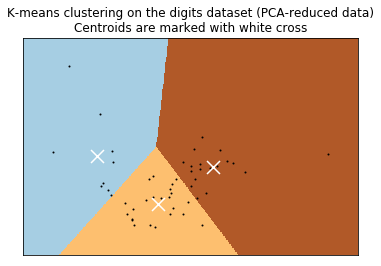

In [62]:
def main(i):
    names = ['pds_ht2_y',
'pds_skin2_y',
'pds_bdyhair_y',
'pds_m4_y',
'pds_m5_y',
'interview_age',
'anthroheightcalc', 
'anthroweightcalc',
'anthro_waist_cm',
'hormone_scr_dhea_mean',
'hormone_scr_hse_mean',
'labels_pred',
'labels_true']
    
    Clusters = []
    Cluster_space = []
    Centroids = []
    
    Comp = []
    Var_ratio = []
    
    Targets = []
    all_dicts = []
    
    Comb_data = []
    
    Lev1_VarRatio = []
    Lev2_VarRatio = []
    Lev3_VarRatio = []
    
    kmeans = []
    for x in range(0,i):
        print(x)
        Q = random_selct(trans,i)
        Clusters.append(Q[0])
        Cluster_space.append(Q[1])
        Centroids.append(Q[2])
        
        Targets.append(Q[3])
        all_dicts.append(Q[4])
        
        Comp.append(Q[5])
        Var_ratio.append(Q[6])
        
        Comb_data.append(Q[7])
        
        Lev1_VarRatio.append(Q[8].transpose())
        Lev2_VarRatio.append(Q[9].transpose())
        Lev3_VarRatio.append(Q[10].transpose())
        
        kmeans.append(Q[11])
        
    All_lev1Ratio = np.vstack(Lev1_VarRatio)
    All_lev2Ratio = np.vstack(Lev2_VarRatio)
    All_lev3Ratio = np.vstack(Lev3_VarRatio)
    
    All_clust = np.hstack(Clusters)
    All_clust_space = np.vstack(Cluster_space)
    
    All_labels = np.hstack(Targets)
    All_dicts = np.hstack(all_dicts)
    
    All_comp = np.vstack(Comp)
    All_var_ratio = Var_ratio
    All_data = np.vstack(Comb_data)
    print(All_data)
    print(All_data.shape)
    All_data=pd.DataFrame(data=All_data[1:,1:],index=All_data[1:,0])
    return (All_clust ,All_clust_space,
            All_labels , All_dicts,
            All_comp, All_var_ratio,
            All_data, names,
            All_lev1Ratio, All_lev2Ratio, All_lev3Ratio,
            kmeans, trans, All_dicts)
i = 5
FINAL = []
FINAL=main(5)
# if __name__ == "__main__": 
#     pool = Pool(processes=2)
#     FINAL = pool.map(main, (i,i)) 

In [63]:
len(FINAL)

14

In [65]:
variables = ['All_clust' ,'All_clust_space',
             'All_labels' , 'All_index',
             'All_comp', 'All_var_ratio',
             'All_data', 'names',
             'All_lev1Ratio', 'All_lev2Ratio',
             'All_lev3Ratio', 'kmeans', 'DATA','All_dicts']
# a, b in x
dict1 ={}
dict2 ={}
dicts = [dict1, dict2]
print(len(FINAL))
i=0
for item in FINAL:
    dicti = dicts[i]
    i=i+1
    ii= 0
    for value in item:
        dicti[variables[ii]] = value
        ii=ii+1

14


IndexError: list index out of range

In [ ]:
dict1['All_data']

In [ ]:
ds = [dict1, dict2]
d = {}
for k in dict1.iterkeys():
    d[k] = tuple(d[k] for d in ds)

All_lev1Ratio = np.vstack(d['All_lev1Ratio'])
All_lev2Ratio = np.vstack(d['All_lev2Ratio'])
All_lev3Ratio = np.vstack(d['All_lev3Ratio'])

All_clust = np.hstack(d['All_clust'])
All_clust_space = np.vstack(d['All_clust_space'])

All_labels = np.hstack(d['All_labels'])
All_index = np.hstack(d['All_index'])

All_comp = np.vstack(d['All_comp'])
# All_var_ratio = Var_ratio

All_data = dict1['All_data'].reset_index().merge(dict2['All_data'], how="left").set_index('index')

All_DATA = np.vstack(d['DATA'])

In [ ]:
All_data

## Taking the variance from each K mean cluster and PCA, using PCA to find the most important factors over all

In [ ]:
All_Ratios = {'Lev1': All_lev1Ratio, 'Lev2': All_lev2Ratio, 'Lev3':All_lev3Ratio}
Coefs = {}
index = np.arange(11)
for key, value in All_Ratios.iteritems(): 
    pca = PCA(n_components=2)
    pca.fit_transform(value)
    i = np.identity(value.shape[1])  # identity matrix
    Coefs[key] = pca.transform(i)
    print(key)
    print pd.DataFrame(pca.components_,columns=names[0:11],index = ['PC-1','PC-2'])
    print('\n')
    
    n_groups = 11

    means_CP1 = np.absolute(pca.components_[0,:])
    std_CP1 = np.matrix.std(np.matrix(np.absolute(pca.components_[0,:])))

    means_CP2 = np.absolute(pca.components_[1,:])
    std_CP2 = np.matrix.std(np.matrix(np.absolute(pca.components_[1,:])))

    fig, ax = plt.subplots(figsize=(45, 20))
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, means_CP1, bar_width,
                    alpha=opacity, color='b',
                    yerr=std_CP1, error_kw=error_config,
                    label='Component 1')

    rects2 = ax.bar(index + bar_width, means_CP2, bar_width,
                    alpha=opacity, color='r',
                    yerr=std_CP2, error_kw=error_config,
                    label='Component 2')
    #plt.xlabel( fontsize=18)
    ax.set_xlabel('Factors', fontsize = 50)
    ax.set_ylabel('Coefficient Weight (Beta)', fontsize = 50)
    ax.set_title('Which factors are the most meaning full for %s cluster'%key, fontsize = 50)
    ax.set_xticks(index + bar_width / 2)
    
    ax.set_xticklabels(names[0:11], fontsize = 28, rotation = -15)
    ax.legend()
    ax.tick_params(labelsize = 38)

    fig=plt.figure(figsize=(100, 16), dpi= 80, facecolor='w', edgecolor='k')
    fig.tight_layout()
    plt.show()
    

In [ ]:
All_data

## Looking at the data

merging the original and new data sets on the indexes

In [ ]:
All_data

In [ ]:
testData = pd.DataFrame(data = dudes)
# print(dudes)
# print(testData)
# pd.merge(df1, df2, on = ['Name', 'Parent', 'Parent_Addr'], how = 'outer')

total = All_data.reset_index().merge(testData, on = 'labels_true', how = 'left').set_index('index')
print(list(All_data.columns.values))
print(list(testData.columns.values))
print(list(total.columns.values))
# total['INDY'] = total.index
total_g = total.groupby(['sub'],axis = 0).mean()
total_g['labels_predR'] = total_g['labels_pred'].round()
total_g

In [ ]:
x=total_g.groupby(['labels_predR'], axis =0).describe()
x['anthroweightcalc_y']#weight lbs

In [ ]:
T=total_g.groupby(['labels_predR'], axis =0).describe()
T['hormone_scr_hse_meanR'] #testosterone

In [ ]:
WC=total_g.groupby(['labels_predR'], axis =0).describe()
WC['anthro_waist_cmR']# waist circ

In [ ]:
Skin=total_g.groupby(['labels_predR'], axis =0).describe()
Skin['pds_skin2_yR']# skin

In [ ]:
total_g['pds_skin2_yR'].std()

## A Nice Plot example

In [ ]:
# # print(All_data)
# # df2 = pd.DataFrame(group.describe().rename(columns={'interview_age':labels_pred}).squeeze()
# #                          for name, group in All_data.groupby('labels_pred'))

# # print(df2)
# subs=list(All_data.index.values)
# len(subs)
# All_data.interview_age.describe()

In [ ]:
n_groups = 3

listOcool = ['pds_skin2_y_y', 'anthro_waist_cm_y', 'anthroweightcalc_y', 'hormone_scr_hse_mean_y']

for item in listOcool:
    means_CP1 = total_g['%s'%item].mean()
    std_CP1 = total_g['%s'%item].std()

    fig, ax = plt.subplots(figsize=(45, 20))

    index = np.arange(n_groups)
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, means_CP1, bar_width,
                    alpha=opacity, color='b',
                    yerr=std_CP1, error_kw=error_config,
                    label=item)

    ax.set_xlabel('%s'%item, fontsize = 50)
    ax.set_ylabel('Mean and Standard Deviation of %s'%item, fontsize = 50)
    
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(names[0:12], fontsize = 28)
    ax.legend()
    ax.tick_params(labelsize = 38)

    fig=plt.figure(figsize=(100, 16), dpi= 80, facecolor='w', edgecolor='k')
    fig.tight_layout()
    plt.show()

In [ ]:
total_g.to_csv('/Users/gracer/Google Drive/ABCD/important_txt/male_puberty_ana.csv', sep=',')

In [ ]:
print(indexes)

want this but colored the dots each time

In [ ]:
varsy =[dudes, dict1, dict2] 

In [ ]:
all_vars = {}
keys = vars =['All_clust' ,'All_clust_space','All_labels' , 
              'All_index', 'All_comp', 'All_var_ratio','All_data', 
              'names',' All_lev1Ratio', 'All_lev2Ratio',' All_lev3Ratio', 'kmeans'] 

for i in range(0,len(keys)):
    all_vars[keys[i]] = varsy[i]


In [ ]:
import pickle

filename = '/Users/gracer/Google Drive/ABCD/important_txt/male_data2.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(all_vars, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print all_vars == b

In [ ]:
import pickle

In [ ]:
# with open("/Users/gracer/Google Drive/ABCD/important_txt/male_data2.pickle", "rb") as input_file:
#     x=pickle.load(input_file)


* All_clust (180,)<- length of the subjects over all runs
* All_clust_space(180,)<-length of the subjects over all runs
* All_means(180,)<-length of the subjects
* All_labels(180,) <- length of subjects True Labels
* All_index(180,)<-length of subjects Index of the original data
* All_comp(18, 12)<- rows are the the PCA components, times the number of the levels, and the number of runs. cols are the factors
* All_var_ratio(108, 2)<-rows are the number of runs, times the number of factors, times the number of levels
* All_var(3, 6)<- rows are the number of runs, the columns are the PCA componenets times the number of levels
* All_mean(9, 12)<- rows are the number of runs by the number of levels the columns are the number of factors
* All_data(180, 14)<-rows are the number of subjects, the columns are number of factors plus the index, plus the components

* components_ : array, shape (n_components, n_features)

* explained_variance_ratio_ : array, shape (n_components,)

*  singular_values_ : array, shape (n_components,)

*  mean_ : array, shape (n_features,)

*  n_components_ : int

*  noise_variance_ : float